In [1]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
df = pd.read_csv('out.csv')
df.shape

(29913, 5)

In [4]:
df.head()

,tag,depth,content,height,road_name
0,body,1,"\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\nLocation\nSG\n\n\nHK \n\nDubai \n\n\n\n\n Directory – Directory Post Type for SassyMediaGroupPregnancy – Pregnancy Post Type for SassyMediaGroupGiveawaySchools\n\nSearch\n\n\n\n EatEating InEating OutFamily FriendlyDate Night / Sans KidsRecipesExpertsView allNew Restaurants in Singapore this December: Foodie News FlashPosted 2 days ago | By BeateNew Restaurants in Singapore this December: Foodie News FlashRestaurant News & New Menus in Singapore: Hot Off The Hob NovemberPosted 1 week ago | By BeateRestaurant News & New Menus in Singapore: Hot Off The Hob NovemberFrom Stretch Marks to Your Hospital Bag: Taking Care of Your Body Before, During & After PregnancyPosted 1 week ago | By Sassy MamaFrom Stretch Marks to Your Hospital Bag: Taking Care of Your Body Before, During & After…TravelInspiration & TipsShort HaulLong HaulGuidesExpertsView allKid-Friendly Penang: Beach, Waterslides and an ‘Adventure Zone’ at Shangri-La’s Golden Sands Re...",20,Geylang Serai
1,NaN,1,\n,0,NaN
2,div,1,"\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\nLocation\nSG\n\n\nHK \n\nDubai \n\n\n\n\n Directory – Directory Post Type for SassyMediaGroupPregnancy – Pregnancy Post Type for SassyMediaGroupGiveawaySchools\n\nSearch\n\n\n\n EatEating InEating OutFamily FriendlyDate Night / Sans KidsRecipesExpertsView allNew Restaurants in Singapore this December: Foodie News FlashPosted 2 days ago | By BeateNew Restaurants in Singapore this December: Foodie News FlashRestaurant News & New Menus in Singapore: Hot Off The Hob NovemberPosted 1 week ago | By BeateRestaurant News & New Menus in Singapore: Hot Off The Hob NovemberFrom Stretch Marks to Your Hospital Bag: Taking Care of Your Body Before, During & After PregnancyPosted 1 week ago | By Sassy MamaFrom Stretch Marks to Your Hospital Bag: Taking Care of Your Body Before, During & After…TravelInspiration & TipsShort HaulLong HaulGuidesExpertsView allKid-Friendly Penang: Beach, Waterslides and an ‘Adventure Zone’ at Shangri-La’s Golden Sands Reso...",19,Geylang Serai
3,NaN,1,\n,0,NaN
4,a,1,Skip to content,1,NaN


# Data cleaning

In [5]:
df['content'] = df['content'].str.replace('[\n\t ]', ' ').str.replace('\s+', ' ').fillna('')

# Feature engineering

In [6]:
df['length'] = df['content'].str.len()

In [7]:
df['has_unit_no'] = df['content'].str.contains(r'#\d+\s{0,3}-\s{0,3}\d+').astype(int)

In [8]:
df['has_postal_code'] = df['content'].str.contains(r'(?:ingapore|S)\s*\(?\d{6}\)?').astype(int)

In [9]:
df['has_address_label'] = df['content'].str.contains(r'[Aa]ddr(?:ess)?:?').astype(int)

In [10]:
df['content_stripped'] = df['content'].str.translate(str.maketrans('', '', string.punctuation + string.digits)).str.replace('\s+', ' ').str.strip()

In [11]:
df['n_words_debug'] = df['content'].str.translate(str.maketrans('', '', string.punctuation)).str.replace('\s+', ' ').str.strip().str.replace(' ', '#')
df['n_words'] = df['content'].str.translate(str.maketrans('', '', string.punctuation)).str.replace('\s+', ' ').str.strip().str.count(' ')
# If count is 0, there are no words, so don't just add 1 to all rows
df.loc[df['n_words'] > 0, 'n_words'] += 1

# Pruning

In [12]:
df = df[(4 <= df['n_words']) & (df['n_words'] <= 50)]

All those with 0 height are tagless.

In [13]:
df[df['height'] == 0]['tag'].unique()

array([nan], dtype=object)

In [14]:
df['road_name'].fillna("", inplace=True)

In [15]:
df = df.sort_values(by='height').drop_duplicates(subset='content')

# Preprocessing

In [16]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [17]:
preprocess = make_column_transformer(
    (StandardScaler(), ['height', 'depth', 'length', 'n_words']),
    ('passthrough', ['has_unit_no', 'has_postal_code', 'has_address_label']),
    (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NO_TAG'),
                   OneHotEncoder()), 
     ['tag']),
    (TfidfVectorizer(stop_words='english'),
     'content_stripped'),
    (TfidfVectorizer(stop_words='english'),
     'road_name')
)

In [18]:
X = preprocess.fit_transform(df)
X

/home/ackerleytng/.pyenv/versions/3.7.2/envs/extracting-event-address/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ackerleytng/.pyenv/versions/3.7.2/envs/extracting-event-address/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<2114x3850 sparse matrix of type '<class 'numpy.float64'>'
	with 27041 stored elements in Compressed Sparse Row format>

# Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [20]:
reducer = umap.UMAP()
reducer.fit(X.todense())

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [21]:
X_2d = reducer.embedding_

For n_clusters = 2 The average silhouette_score is : 0.34286125027648584
For n_clusters = 4 The average silhouette_score is : 0.25762622088598136
For n_clusters = 6 The average silhouette_score is : 0.25180723686710665
For n_clusters = 8 The average silhouette_score is : 0.18650586163589802


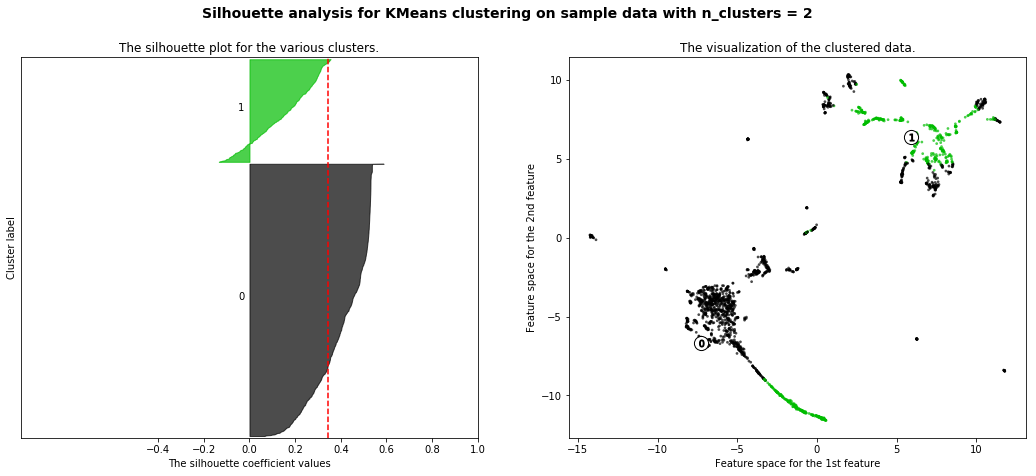

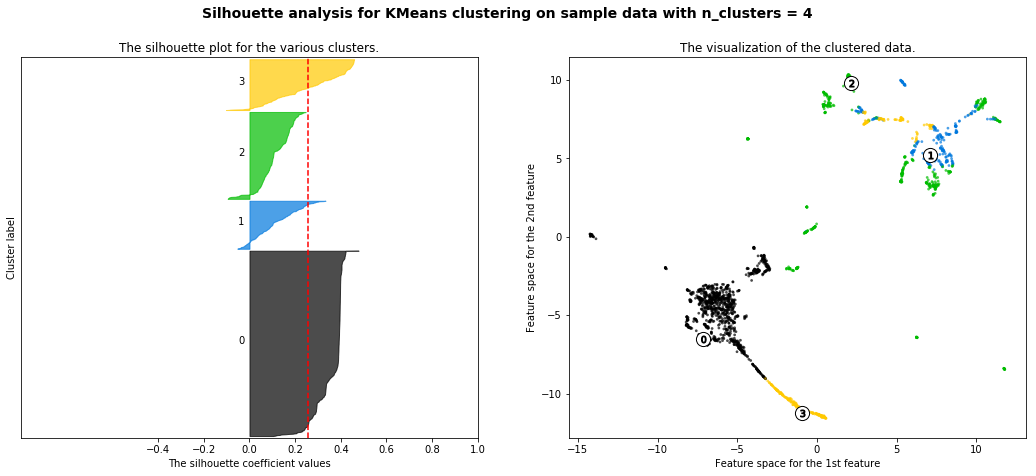

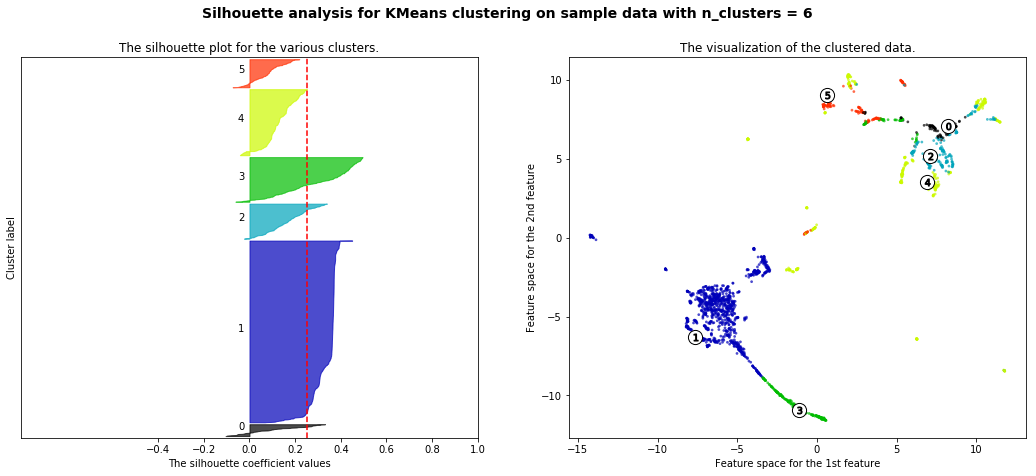

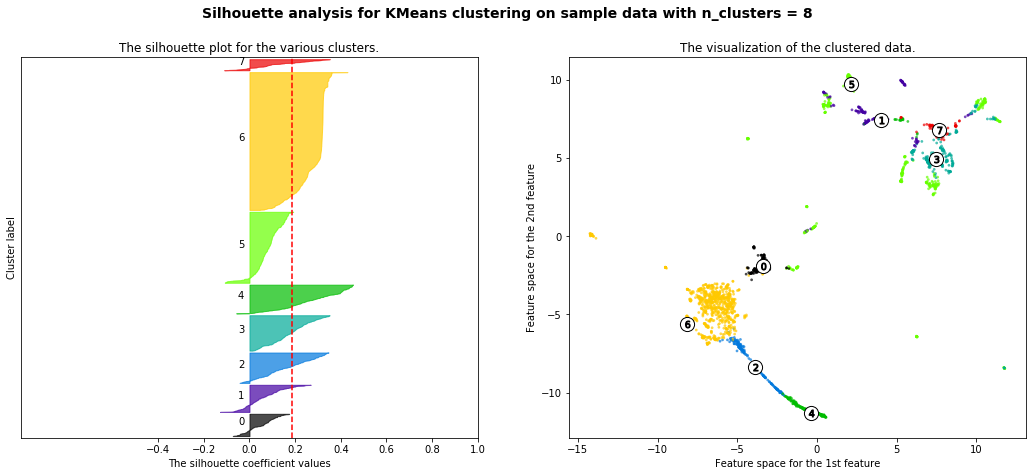

In [22]:
for n_clusters in range(2, 10, 2):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)   
    ax2.scatter(X_2d[:, 0], X_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = reducer.transform(clusterer.cluster_centers_)    
  
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f'${i}$', alpha=1,
                    s=50, edgecolor='k')
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  f"with n_clusters = {n_clusters}"),
                 fontsize=14, fontweight='bold')

plt.show()

In [23]:
n_clusters = 8

In [24]:
kmeans = KMeans(n_clusters=n_clusters, random_state=17)

In [25]:
kmeans.fit(X)
len(kmeans.labels_)

2114

In [26]:
import bokeh.plotting as bk
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import viridis

bk.output_notebook()

Loading BokehJS ...

In [27]:
source = ColumnDataSource(data={
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
    'content': df['content'].str.slice(0, 60),
    'colors': [viridis(n_clusters)[l] for l in kmeans.labels_],
    'labels': kmeans.labels_
})

p = bk.figure(
    plot_width=800, 
    plot_height=800
)
p.scatter(x='x', y='y', 
          radius=0.1, 
          fill_color='colors', fill_alpha=0.4, 
          line_color=None,
          source=source)

p.add_tools(HoverTool(
    tooltips=[
        ("index", "$index"),
        ("content", "@content"),
        ('label', '@labels')
    ],
))

bk.show(p)